In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df:pd.DataFrame = pd.read_csv('../data/BTC_USDT_1h.csv')

In [3]:
df

,timestamp,open,high,low,close,volume
0,2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399
1,2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826
2,2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668
3,2023-01-01 03:00:00,16542.5,16542.5,16515.0,16529.3,3214.480
4,2023-01-01 04:00:00,16529.2,16530.4,16508.8,16517.8,3150.954
...,...,...,...,...,...,...
8978,2024-01-10 02:00:00,45944.5,46104.8,45898.9,45990.0,5315.192
8979,2024-01-10 03:00:00,45989.9,46228.4,45939.4,46133.6,6154.987
8980,2024-01-10 04:00:00,46133.5,46200.0,45950.0,45970.4,6028.925
8981,2024-01-10 05:00:00,45970.4,46036.6,45903.0,45988.4,4137.107


In [4]:
# Data Preprocessing

## Drop null values

df = df.dropna()

## Convert string to datetime

df['date'] = pd.to_datetime(df['timestamp'])

## Drop timestamp column

df = df.drop('timestamp', axis=1)

## Set date as index

df = df.set_index('date')

## Sort by date

df = df.sort_index()

## Change price to percentage change

df['open'] = df['open'].pct_change()
df['high'] = df['high'].pct_change()
df['low'] = df['low'].pct_change()
df['close'] = df['close'].pct_change()
df['volume'] = df['volume'].pct_change()

## Drop first row

df = df.drop(df.index[0])

## Show data

df

,open,high,low,close,volume
date,,,,,
2023-01-01 01:00:00,-0.000629,0.000810,0.001218,0.001416,-0.403347
2023-01-01 02:00:00,0.001416,0.000169,0.000648,-0.000483,-0.252632
2023-01-01 03:00:00,-0.000483,-0.000882,-0.001197,-0.000792,0.339552
2023-01-01 04:00:00,-0.000804,-0.000731,-0.000375,-0.000696,-0.019762
2023-01-01 05:00:00,-0.000690,0.000042,-0.000048,0.000478,0.037239
...,...,...,...,...,...
2024-01-10 02:00:00,0.001757,0.002703,0.005902,0.000993,-0.454137
2024-01-10 03:00:00,0.000988,0.002681,0.000882,0.003122,0.157999
2024-01-10 04:00:00,0.003122,-0.000614,0.000231,-0.003538,-0.020481


In [5]:
# Make data

## split into chunks

def split_data(data, chunk_size):
    chunks = []
    for i in range(len(data) - chunk_size):
        chunks.append(data[i:i+chunk_size].to_numpy())
    return chunks

## split data

chunk_size = 10
data = split_data(df, chunk_size)

## show data

len(data)

8972

In [6]:
# data[0].to_numpy().shape
data[0].shape

(10, 5)

In [7]:
# import torch and torch dataset and dataloader

import torch
import torch.onnx as onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
# Create dataset

class CryptoDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
dataset = CryptoDataset(data)

# Create dataloader

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create model

class TimeSeriesEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TimeSeriesEncoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 64)
        self.conv1 = nn.Conv1d(64, 32, 1)
        self.lstm2 = nn.LSTM(32, hidden_size)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(1, 2, 0)
        x = self.conv1(x)
        x = x.permute(2, 0, 1)
        x, _ = self.lstm2(x)
        return x
    
class TimeSeriesDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(TimeSeriesDecoder, self).__init__()
        self.lstm1 = nn.LSTM(hidden_size, 32)
        self.conv1 = nn.Conv1d(32, 64, 1)
        self.lstm2 = nn.LSTM(64, output_size)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(1, 2, 0)
        x = self.conv1(x)
        x = x.permute(2, 0, 1)
        x, _ = self.lstm2(x)
        return x

class TimeSeriesEncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesEncoderDecoder, self).__init__()
        self.encoder = TimeSeriesEncoder(input_size, hidden_size)
        self.decoder = TimeSeriesDecoder(hidden_size, output_size)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Check data shape
data = next(iter(dataloader))
data.shape

torch.Size([32, 10, 5])

In [10]:
EPOCHS = 3
# Create model

model = TimeSeriesEncoderDecoder(5, 4, 5)

# Create loss function

criterion = nn.MSELoss()

# Create optimizer

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create Learning Rate Scheduler

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion.to(device)

model.train()

loss_history = []

for epoch in range(EPOCHS):
    temp_loss = []
    for i, data in enumerate(dataloader):
        data = data.to(device).float()
        optimizer.zero_grad()
        # print(data.shape)
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())
        if i % 100 == 0:
            print(f'Epoch: {epoch+1}, Loss: {loss.item()}', end='\r')
    scheduler.step()
    loss_history.append(np.mean(temp_loss))
    print(f'Epoch: {epoch+1}, Loss: {np.mean(temp_loss)}, Learning Rate: {scheduler.get_last_lr()[0]}')

Epoch: 1, Loss: 0.22640913585698053, Learning Rate: 0.0075
Epoch: 2, Loss: 0.2149520339941427, Learning Rate: 0.002500000000000001
Epoch: 3, Loss: 0.21498359401720274, Learning Rate: 0.0


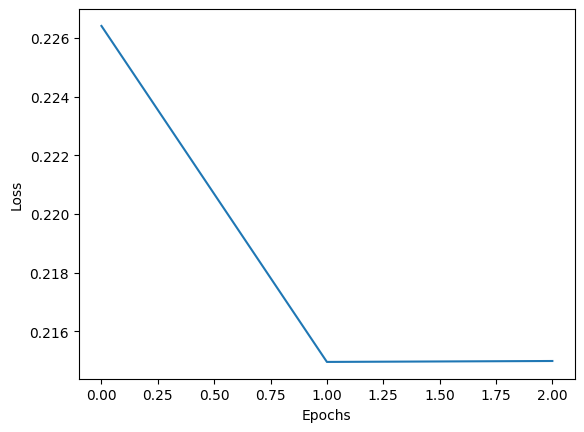

In [11]:
# Plot loss

plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
# make data for training predictor

new_data = split_data(df, chunk_size)

def timeseries_data_chunk(data:list, chunk_size):
    chunks = []
    for i in range(len(data) - chunk_size):
        chunks.append(data[i:i+chunk_size])
    return chunks

new_data = timeseries_data_chunk(new_data, chunk_size)

len(new_data)

8962

In [13]:
def make_x_y(data):
    x = []
    y = [] # up or down or natural
    for i in range(len(data) - 1):
        x.append(data[i])
        if data[i+1][0][3][0] > 0:
            y.append(1) # up
        elif data[i+1][0][3][0] < 0:
            y.append(0) # down
        else:
            y.append(2) # natural
    return x, y

x, y = make_x_y(new_data)

In [14]:
len(x), len(y)

(8961, 8961)

In [15]:
# Create dataset

class CryptoPredictorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset = CryptoPredictorDataset(x, y)

# Create dataloader

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\hiban\AppData\Local\Temp\ipykernel_9716\2932353887.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  self.x = torch.tensor(x)


In [16]:
testdata = next(iter(dataloader))

In [17]:
testdata[0].shape, testdata[1].shape

(torch.Size([32, 10, 10, 5]), torch.Size([32]))

In [18]:
testdata[0][:,0].shape

torch.Size([32, 10, 5])

In [19]:
# Create model

class TimeSeriesPredictor(nn.Module):
    def __init__(self, pretrained_EncoderDecoder, hidden_size, output_size):
        super(TimeSeriesPredictor, self).__init__()
        self.encoder = pretrained_EncoderDecoder.encoder
        self.predictor = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_var_list = []
        for i in range(x.shape[1]):
            x_var_list.append(self.encoder(x[:, i]))
        x1 = torch.stack(x_var_list)
        x1 = x1.permute(1, 0, 2, 3)
        x1 = x1.mean(dim=1)
        x1 = self.predictor(x1)
        x1 = x1[:, -1, :]
        return x1

In [20]:
for parm in model.parameters():
    parm.requires_grad = False

new_model = TimeSeriesPredictor(model, 4, 3)

new_model.to(device)

# test output
new_model(testdata[0].to(device).float()).shape

torch.Size([32, 3])

In [21]:
# Create loss function

criterion = nn.CrossEntropyLoss()

# Create optimizer

optimizer = optim.Adam(new_model.parameters(), lr=0.01)

# Create Learning Rate Scheduler
EPOCHS = 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

# Train model

new_model.train()

loss_history = []
accuracy_history = []

for epoch in range(EPOCHS):
    temp_loss = []
    temp_accuracy = []
    for i, data in enumerate(dataloader):
        x, y = data
        x = x.to(device).float()
        y = y.to(device)
        optimizer.zero_grad()
        output = new_model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())
        accuracy = (output.argmax(1) == y).sum().item() / len(y)
        temp_accuracy.append(accuracy)
        if i % 100 == 0:
            print(f'Epoch: {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}', end='\r')
    scheduler.step()
    loss_history.append(np.mean(temp_loss))
    accuracy_history.append(np.mean(temp_accuracy))
    print(f'Epoch: {epoch+1}, Loss: {np.mean(temp_loss)}, Accuracy: {np.mean(temp_accuracy)}, Learning Rate: {scheduler.get_last_lr()[0]}')

Epoch: 1, Loss: 0.7883264789377668, Accuracy: 0.5024466192170819, Learning Rate: 0.009755282581475769
Epoch: 2, Loss: 0.7098389176711493, Accuracy: 0.5126779359430605, Learning Rate: 0.009045084971874737
Epoch: 3, Loss: 0.7043655656834938, Accuracy: 0.5038923487544484, Learning Rate: 0.007938926261462366
Epoch: 4, Loss: 0.7025293599668346, Accuracy: 0.5062277580071174, Learning Rate: 0.006545084971874737
Epoch: 5, Loss: 0.7015541537376485, Accuracy: 0.5083407473309609, Learning Rate: 0.005
Epoch: 6, Loss: 0.7004720441387218, Accuracy: 0.515346975088968, Learning Rate: 0.003454915028125263
Epoch: 7, Loss: 0.7008344944685804, Accuracy: 0.5104537366548043, Learning Rate: 0.0020610737385376348
Epoch: 8, Loss: 0.7003013676171626, Accuracy: 0.5114546263345195, Learning Rate: 0.0009549150281252633
Epoch: 9, Loss: 0.7001132468736044, Accuracy: 0.5154581850533808, Learning Rate: 0.00024471741852423234
Epoch: 10, Loss: 0.7002625149339968, Accuracy: 0.5096752669039146, Learning Rate: 0.0


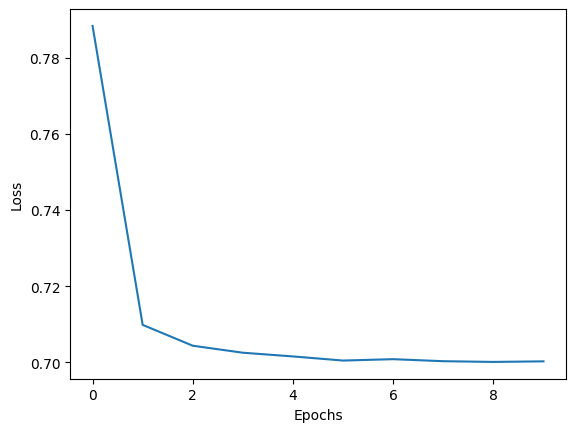

In [22]:
# plot loss

plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

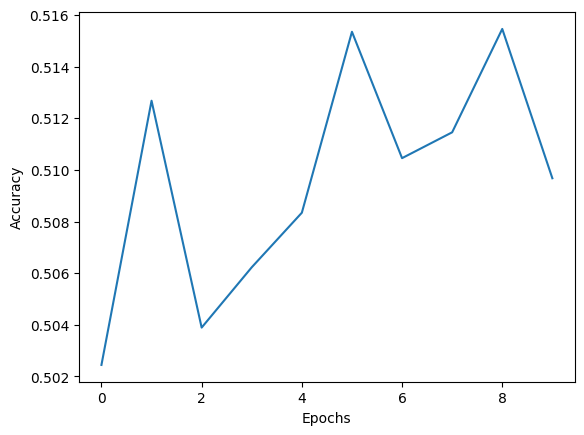

In [23]:
# plot accuracy

plt.plot(accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [24]:
# output as onnx

dummy_input = torch.randn(1, 10, 10, 5).to(device)
onnx.export(new_model, dummy_input, '../model/crypto_predictor.onnx')

c:\Program Files\Python311\Lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [25]:
new_model

TimeSeriesPredictor(
  (encoder): TimeSeriesEncoder(
    (lstm1): LSTM(5, 64)
    (conv1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (lstm2): LSTM(32, 4)
  )
  (predictor): Linear(in_features=4, out_features=3, bias=True)
)